#### In this problem we use "Transfer Learning" of an Object Detector model to detect any object according to the problem in hand.

Here, We are particularly interested in detecting faces in a given image.

#### To use the model first, we need to import the model and its supporting files for the model to function. 

We see the below steps to import the model.

### First lets install numpy and restart the runtime.  Go to: Runtime > Restart runtime in the top menu

You can comment or skip the below command after running once in a runtime. 

In [1]:
!pip install numpy==1.16.1

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\Public\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\Public\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Public\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Public\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Public\Anaconda3\lib\site-packages\pip\_

### Import MobileNet model given in file `mn_model.py`

In [2]:
### Import MobileNet model given in file `mn_model.py`

from mn_model import mn_model

Using TensorFlow backend.


### Import the BatchGenerator and SSDLoss functions in given files `face_generator.py`, `keras_ssd_loss` and `ssd_box_encode_decode_utils.py` as well, used in MobileNet model

In [3]:
#### Import the BatchGenerator and SSDLoss functions as well, used in MobileNet model

from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

In [30]:

import warnings
warnings.filterwarnings("ignore")

from keras.optimizers import Adam, SGD, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.callbacks import Callback
from keras import backend as K 
from keras.models import load_model
from math import ceil 
import numpy as np 
from termcolor import colored

from mn_model import mn_model
from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2

# training parameters
from keras import backend as K
import scipy.misc as sm


## Set the parameters for the model

#### We need to customize the model parameters according to our problem as given below.

#### Set n_classes (no.of classes) = 2, as we are interested in only face detection. 
#### `Face` will be one class and everything else comes under other class (we can call it as `background`)

#### Set class_names = ["background", "face"]

In [5]:
img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

det_model_path = "./"

### Now, we have imported the model and its dependencies. The next thing is to import the dataset for the model to train on. For this, we are using the WIDER FACE dataset. 

#### To make the dataset available follow the steps given below.


1. Create a folder in your google drive for this project. 

2. Download the train and test dataset files given in .zip format into your drive folder you created for the project in step-1.

3. Set the project path variable according to the folders you created to use for this project in your google drive. 

      `project_path = "/content/drive/My Drive/DLCP/"`

4. Now, as we mount the drive the images will be available to use for training and testing but in zip format.

5. So, lets extract the images from the zipfiles by using the code given of zipfile module.







In [6]:
#from google.colab import drive

In [7]:
#drive.mount('/content/drive')

In [8]:
#project_path = "/content/drive/My Drive/DLCP/"

In [9]:
#train_images_path =   'WIDER_train.zip'
#test_images_path =  'WIDER_val.zip'

In [10]:
#import zipfile
#archive = zipfile.ZipFile(train_images_path, 'r')
#archive.extractall()

In [11]:
#archive = zipfile.ZipFile(test_images_path, 'r')
#archive.extractall()

### Now, the images are available. The next thing we need is to get the labels for these images, so that we can use this information while training for detecting faces with the given model using transfer learning. 

#### Follow the below steps to get those labels available.


Load the  '' `wider_train_small.npy`'' file given to check the information given about the dataset. In this file you can see the information about each image in the dataset in a list with following elemets:
      

        1.   Image filename (str)
        2.   Image filename (str)
        3.   Image size (list) [height, width]
        4.   List of bounding box co-ordinates and Class label (list) [[a,b,c,d], Class label, ...]
        
        where,
        a,b,c,d are the four co-ordinates of the bounding box
        Class label is the position of object as mentioned in `class_names` list above.

In [12]:
data = np.load('./wider_train_small.npy').item()

In [13]:
### Printed first element to check the above given information.

for key in data:
    print(key)
    print (data[key])
    break

52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg
['WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', 'WIDER_train/images/52--Photographers/52_Photographers_photographertakingphoto_52_582.jpg', [300, 300], [[21, 667, 9, 655], 1]]


 As we can see from the above output all the information mentioned above is there for all the images.

### Now, load the files `wider_trian.npy` and `wider_val.npy`

In [14]:
train_data = 'wider_train_small.npy'
test_data = 'wider_val_small.npy'

x = np.load(train_data)

### Now, call the imported model with the given parameters and freeze all the layers in the model with names not having ''`detection`'' word as prefix.

As we are not training the model from scratch, we are freezing all the above layers in the model having only last few layers while training to update their weights according to the problem in hand. This is called as **Transfer Learning**.

In [15]:
# build the keras model
# this model is not retrained, we are doing it from scratch 

K.clear_session()
model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)




====> Model Specific data
====> Height, Width, Channels : 512 512 3





#### Write code to freeze all the layers in the above model with names not having ''`detection`'' word as prefix.

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda1 (Lambda)                (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda2 (Lambda)                (None, 512, 512, 3)  0           lambda1[0][0]                    
__________________________________________________________________________________________________
lambda3 (Lambda)                (None, 512, 512, 3)  0           lambda2[0][0]                    
__________________________________________________________________________________________________
conv1 (Con

__________________________________________________________________________________________________
conv_pw_6 (Conv2D)              (None, 32, 32, 512)  131072      conv_dw_6_relu[0][0]             
__________________________________________________________________________________________________
conv_pw_6_bn (BatchNormalizatio (None, 32, 32, 512)  2048        conv_pw_6[0][0]                  
__________________________________________________________________________________________________
conv_pw_6_relu (Activation)     (None, 32, 32, 512)  0           conv_pw_6_bn[0][0]               
__________________________________________________________________________________________________
conv_dw_7 (DepthwiseConv2D)     (None, 32, 32, 512)  4608        conv_pw_6_relu[0][0]             
__________________________________________________________________________________________________
conv_dw_7_bn (BatchNormalizatio (None, 32, 32, 512)  2048        conv_dw_7[0][0]                  
__________

__________________________________________________________________________________________________
conv_dw_13_relu (Activation)    (None, 16, 16, 1024) 0           conv_dw_13_bn[0][0]              
__________________________________________________________________________________________________
conv_pw_13 (Conv2D)             (None, 16, 16, 1024) 1048576     conv_dw_13_relu[0][0]            
__________________________________________________________________________________________________
conv_pw_13_bn (BatchNormalizati (None, 16, 16, 1024) 4096        conv_pw_13[0][0]                 
__________________________________________________________________________________________________
conv_pw_13_relu (Activation)    (None, 16, 16, 1024) 0           conv_pw_13_bn[0][0]              
__________________________________________________________________________________________________
detection_conv6_1 (Conv2D)      (None, 16, 16, 256)  262400      conv_pw_13_relu[0][0]            
__________

__________________________________________________________________________________________________
detection_conv4_3_norm_mbox_con (None, 32, 32, 512)  4608        detection_conv4_3_norm[0][0]     
__________________________________________________________________________________________________
detection_fc7_mbox_conf_conv_dw (None, 16, 16, 1024) 9216        conv_pw_13_relu[0][0]            
__________________________________________________________________________________________________
detection_conv6_2_mbox_conf_con (None, 8, 8, 512)    4608        detection_conv6_2_conv_pw_1_relu[
__________________________________________________________________________________________________
detection_conv7_2_mbox_conf_con (None, 4, 4, 256)    2304        detection_conv7_2_conv_pw_2_relu[
__________________________________________________________________________________________________
detection_conv8_2_mbox_conf_con (None, 2, 2, 256)    2304        detection_conv8_2_conv_pw_3_relu[
__________

__________________________________________________________________________________________________
detection_conv9_2_mbox_loc_conv (None, 1, 1, 256)    0           detection_conv9_2_mbox_loc_conv_d
__________________________________________________________________________________________________
detection_conv4_3_norm_mbox_con (None, 32, 32, 8)    32          detection_conv4_3_norm_mbox_conf_
__________________________________________________________________________________________________
detection_fc7_mbox_conf_conv_pw (None, 16, 16, 12)   48          detection_fc7_mbox_conf_conv_pw_2
__________________________________________________________________________________________________
detection_conv6_2_mbox_conf_con (None, 8, 8, 12)     48          detection_conv6_2_mbox_conf_conv_
__________________________________________________________________________________________________
detection_conv7_2_mbox_conf_con (None, 4, 4, 12)     48          detection_conv7_2_mbox_conf_conv_
__________

__________________________________________________________________________________________________
detection_conv8_2_mbox_priorbox (None, 2, 2, 4, 8)   0           detection_conv8_2_conv_pw_3_relu[
__________________________________________________________________________________________________
detection_conv9_2_mbox_priorbox (None, 1, 1, 4, 8)   0           detection_conv9_2_conv_pw_4_relu[
__________________________________________________________________________________________________
detection_mbox_conf (Concatenat (None, 6132, 2)      0           detection_conv4_3_norm_mbox_conf_
                                                                 detection_fc7_mbox_conf_reshape[0
                                                                 detection_conv6_2_mbox_conf_resha
                                                                 detection_conv7_2_mbox_conf_resha
                                                                 detection_conv8_2_mbox_conf_resha
          

In [17]:
# freeze all the layers with names not having ''`detection`'' word as prefix
for layer in model.layers:
    if(not layer.name.startswith("detection")):       
       layer.trainable = False #layer not starting with "detetcion" is set to non trainable++

### After making the model ready for transfer learning, load the weights of the model given in file ''`mobilenet_1_0_224_tf.h5`''

In [18]:
model.load_weights("mobilenet_1_0_224_tf.h5", by_name=True)

#### Using the functions given in the model, we are trying to divide the dataset into train and validation samples. Run the below code.

In [19]:
batch_size = 32
ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

train_dataset = BatchGenerator(images_path=train_data, 
                include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==>TRAINING DATA")
print ("==> Parsing XML files ...")

train_dataset.parse_xml(
                  annotations_path=train_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)
print("==>Parsing XML Finished.")

print ("==>Generate training batches...")
train_generator = train_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=True,
                 brightness=(0.5,2,0.5),
                 flip=0.5,
                 translate=((0, 20), (0, 30), 0.5),
                 scale=(0.75, 1.2, 0.5),
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False,
                 resize=(img_height, img_width),
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print ("==>Training batch generation complete")

n_train_samples = train_dataset.get_n_samples()

print ("==>Total number of training samples = {}".format(n_train_samples))

# Now repeat above steps for validation data 

print ("==>VALIDATION")

val_dataset = BatchGenerator(images_path=test_data, include_classes='all', 
                box_output_format = ['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

print ("==> Parsing XML files ...")


val_dataset.parse_xml(
                  annotations_path=test_data,
                  image_set_path='None',
                  image_set='None',
                  classes = class_names, 
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False, 
                  debug = False)


print("==>Parsing XML Finished.")


print ("==>Generate training batches...")
val_generator = val_dataset.generate(
                 batch_size=batch_size,
                 train=True,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False, 
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)


print ("==>Training batch generation complete")

n_val_samples = val_dataset.get_n_samples()

print ("==>Total number of validation samples = {}".format(n_val_samples))

==>TRAINING DATA
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of training samples = 128
==>VALIDATION
==> Parsing XML files ...
==>Parsing XML Finished.
==>Generate training batches...
==>Training batch generation complete
==>Total number of validation samples = 60


### Now, lets setup things for training by initilaizing required variables like learning rate, epochs, optimizer and loss function(SSDLoss) to compile the model

In [20]:
# setting up training 

# batch_size and no.of epochs

batch_size = 16
num_epochs = 10

#Learning rate
base_lr = 0.002

# Optimizer
adam = Adam(lr=base_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-6, decay = 0.0)

# Loss
ssd_loss = SSDLoss(neg_pos_ratio=2, n_neg_min=0, alpha=1.0, beta = 1.0)

# Compile
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


### Lets add early stopping and model checkpoint layers on validation loss with some patience values and using fit_generator function to train the model on data generated batch-by-batch by a Python generator, `train_generator` object as generator.


We are using checkpoint to save the best model based on validation accuracy.

#### Write code for early_stopping and model_checkpoint layers. Using model.fit_generator train the model and save the best weight file.

In [21]:

# utility fxn ffor Initializing Early stopping and Model chekpoint callbacks**
def EarlyStopingModelCheckPoint():

    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 5 continous epochs

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training

    model_checkpoint =  ModelCheckpoint('model_checkpoints/checkpoint_epoch{epoch:02d}_loss{val_loss:.4f}.h5',
                                                               monitor='val_loss',
                                                               verbose=1,
                                                               save_best_only=True,
                                                               save_weights_only=False,
                                                               mode='auto',
                                                               period=1)
    return early_stopping, model_checkpoint


In [23]:

# fit the model
early_stopping, model_checkpoint = EarlyStopingModelCheckPoint()

history = model.fit_generator(generator=train_generator,
                                validation_data=val_generator,
                                epochs=num_epochs,
                                steps_per_epoch=10,
                                validation_steps=3,
                                verbose=1,                     
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/10
10/10 [==============================] - ETA: 52s - loss: 0.22 - ETA: 41s - loss: 0.20 - ETA: 31s - loss: 0.22 - ETA: 25s - loss: 0.21 - ETA: 21s - loss: 0.21 - ETA: 16s - loss: 0.22 - ETA: 13s - loss: 0.23 - ETA: 8s - loss: 0.2323 - ETA: 4s - loss: 0.235 - 45s 5s/step - loss: 0.2318 - val_loss: 0.2547

Epoch 00001: val_loss improved from inf to 0.25467, saving model to model_checkpoints/checkpoint_epoch01_loss0.2547.h5
Epoch 2/10
10/10 [==============================] - ETA: 17s - loss: 0.21 - ETA: 15s - loss: 0.19 - ETA: 13s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 9s - loss: 0.2200 - ETA: 8s - loss: 0.229 - ETA: 6s - loss: 0.226 - ETA: 4s - loss: 0.225 - ETA: 2s - loss: 0.225 - 28s 3s/step - loss: 0.2248 - val_loss: 0.2586

Epoch 00002: val_loss did not improve from 0.25467
Epoch 3/10
10/10 [==============================] - ETA: 17s - loss: 0.22 - ETA: 15s - loss: 0.22 - ETA: 13s - loss: 0.22 - ETA: 12s - loss: 0.22 - ETA: 11s - loss: 0.21 - ETA: 9s - loss: 0.2236 - E

### Load the best saved model from above step and check predictions for test data using test_generator object to generate batches.

#### Write code in the below cell to load best saved model in the above step.

In [ ]:
# best model is saved at checkpoint_epoch09_loss0.2245.h5
model = load_model('model_checkpoints/checkpoint_epoch09_loss0.2245.h5')


### Use the below function to plot the boundingbox in the test image to show the predictions.

In [52]:
def save_bb(path, filename, results, prediction=True):
  
  # print filename

  img = image.load_img(filename, target_size=(img_height, img_width))
  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 25)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1]
      det_xmax = result[2]
      det_ymin = result[3]
      det_ymax = result[4]

    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))
    label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}'.format(score)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[color_code]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.2})

  # y
  currentAxis.axes.get_yaxis().set_visible(False)
  # x
  currentAxis.axes.get_xaxis().set_visible(False)
  plt.savefig(path + filename, bbox_inches='tight')

  print ('saved' , path + filename)

  plt.clf()


#### Run the below code to create a folder with name output_test and get the predictions for the test images using model.predict()

In [53]:
!mkdir output_test

A subdirectory or file output_test already exists.


In [54]:
from keras.preprocessing import image
from matplotlib import pyplot as plt

test_size = 16
test_generator = val_dataset.generate(
                 batch_size=test_size,
                 train=False,
                 ssd_box_encoder=ssd_box_encoder,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 crop=False,
                 #random_crop = (img_height,img_width,1,3), 
                 random_crop=False, 
                 resize=(img_height, img_width), 
                 #resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.4,
                 diagnostics=False)

print (colored("done.", "green"))

print (colored("now predicting...", "yellow"))

_CONF = 0.60 
_IOU = 0.15

for i in range(test_size):
    X, y, filenames = next(test_generator)

    y_pred = model.predict(X)
    y_pred_decoded = decode_y2(y_pred,
                             confidence_thresh=_CONF,
                            iou_threshold=_IOU,
                            top_k='all',
                            input_coords=coords,
                            normalize_coords=normalize_coords,
                            img_height=img_height,
                            img_width=img_width)


    np.set_printoptions(suppress=True)

    save_bb("./output_test/", filenames[i], y_pred_decoded[i])
    save_bb("./output_test/", filenames[i], y[i], prediction=False)


done.
now predicting...
total number of bbs: 1
saved ./output_test/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_21.jpg
total number of bbs: 5
saved ./output_test/12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_21_gt.jpg
total number of bbs: 2
saved ./output_test/35_Basketball_playingbasketball_35_417.jpg
total number of bbs: 16
saved ./output_test/35_Basketball_playingbasketball_35_417_gt.jpg
total number of bbs: 0
saved ./output_test/25_Soldier_Patrol_Soldier_Patrol_25_515.jpg
total number of bbs: 6
saved ./output_test/25_Soldier_Patrol_Soldier_Patrol_25_515_gt.jpg
total number of bbs: 1
saved ./output_test/30_Surgeons_Surgeons_30_554.jpg
total number of bbs: 6
saved ./output_test/30_Surgeons_Surgeons_30_554_gt.jpg
total number of bbs: 2
saved ./output_test/58_Hockey_icehockey_puck_58_285.jpg
total number of bbs: 7
saved ./output_test/58_Hockey_icehockey_puck_58_285_gt.jpg
total number of bbs: 1
saved ./output_test/2_Demonstration_Demonstration_Or_Prot

IndexError: list index out of range

In the above step all the test images along with predictions are stored in output_test folder in this notebook environment. You can check the folder in Files section of the menu to left-side of screen in colab.

Each test image is used for predictions and is stored as 2 files.

one file is the original ground truth with <filename_gt.jpg>
second file is the prediction of the model on the image. with <filename.jpg>

### Visualize a test image to check predictions


#### Write code to show images: Using cv2.imshow() or matplotlib show any 3 test images and their predictions.

In [55]:

import os
test_dir = "./output_test"
testfiles = []
for file in os.listdir(test_dir):
    testfiles.append(file)
    
testfiles[0:5]

['11_Meeting_Meeting_11_Meeting_Meeting_11_176.jpg',
 '11_Meeting_Meeting_11_Meeting_Meeting_11_176_gt.jpg',
 '12_Group_Large_Group_12_Group_Large_Group_12_354.jpg',
 '12_Group_Large_Group_12_Group_Large_Group_12_354_gt.jpg',
 '12_Group_Team_Organized_Group_12_Group_Team_Organized_Group_12_21.jpg']

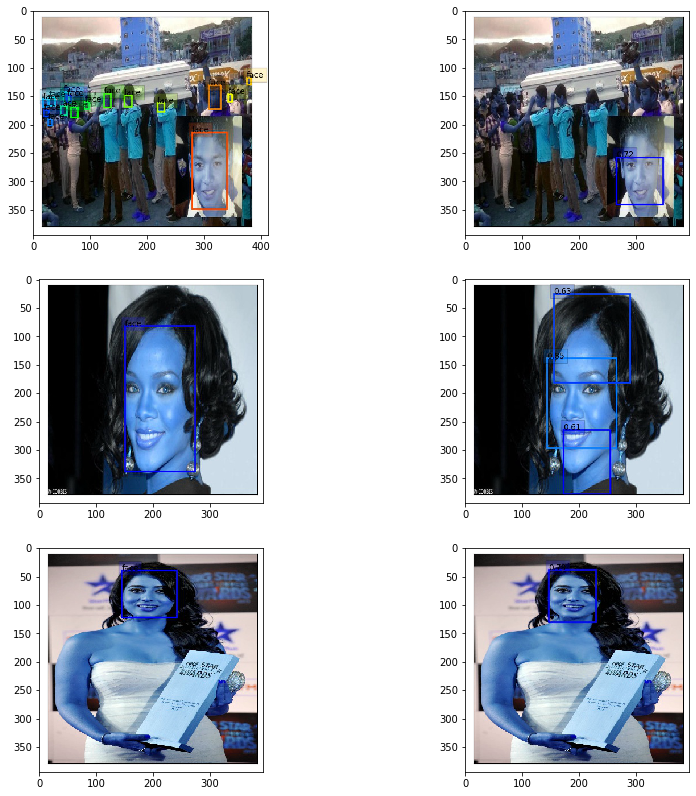

In [56]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

num_imgs = 3

startLoc = 3

fig, axs = plt.subplots(num_imgs,2,figsize=(14,14))

for i in range(num_imgs):    

    pos = 2*(startLoc+i)
    gt_file = '{}/{}'.format(test_dir, testfiles[pos+1])
    img = cv2.imread(gt_file)
    axs[i][0].imshow(img)

    pred_file = '{}/{}'.format(test_dir, testfiles[pos])
    img = cv2.imread(pred_file)
    axs[i][1].imshow(img)
    
plt.show()